In [1]:
from sentence_transformers import SentenceTransformer
from pathlib import Path
from bertopic import BERTopic
import json
import umap
import numpy as np
import matplotlib.pyplot as plt

/storage/homefs/as23z124/.conda/envs/CAS_NLP_M3_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
path = Path('/storage/homefs/as23z124/NLP_CAS_M3_project/goodreads_corpus')

In [4]:
# import jsonl of corpus with topics
jsonl_file = path / 'corpus_table.with_topics.jsonl'

In [5]:
# Prepare data for BERTopic with error handling
descriptions = []
embeddings = []
book_ids = []
skipped = 0

for line in jsonl_file.open():
    try:
        data = json.loads(line)
        desc = data.get('description', '')
        if desc:
            # Try to encode and verify it works
            embedding = emb_model.encode(desc)
            
            # Also check if description has valid characters
            desc_clean = desc.encode('utf-8', errors='ignore').decode('utf-8')
            
            descriptions.append(desc_clean)
            embeddings.append(embedding)
            book_ids.append(data.get('book_id'))
    except Exception as e:
        skipped += 1
        continue

print(f"Loaded {len(descriptions)} book descriptions with embeddings")
print(f"Skipped {skipped} books due to errors")

Loaded 500 book descriptions with embeddings
Skipped 0 books due to errors


In [6]:
NEIGHBORS = [2, 5, 10, 20, 50, 100]
MIN_DIST = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

In [52]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Convert embeddings to numpy array for UMAP
embeddings_array = np.array(embeddings)

# Grid search over UMAP parameters
results = []

for n_neighbors in NEIGHBORS:
    for min_dist in MIN_DIST:
        print(f"Testing n_neighbors={n_neighbors}, min_dist={min_dist}")
        
        # Fit UMAP
        umap_model = umap.UMAP(
            n_components=2, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric='cosine',
            random_state=42
        )
        reduced_embeddings = umap_model.fit_transform(embeddings_array)
        
        # Store results
        results.append({
            'n_neighbors': n_neighbors,
            'min_dist': min_dist,
            'embeddings': reduced_embeddings
        })

print(f"\nCompleted {len(results)} parameter combinations")

Testing n_neighbors=2, min_dist=0.0001
Testing n_neighbors=2, min_dist=0.001
Testing n_neighbors=2, min_dist=0.01
Testing n_neighbors=2, min_dist=0.1
Testing n_neighbors=2, min_dist=0.5
Testing n_neighbors=2, min_dist=1
Testing n_neighbors=5, min_dist=0.0001
Testing n_neighbors=5, min_dist=0.001
Testing n_neighbors=5, min_dist=0.01
Testing n_neighbors=5, min_dist=0.1
Testing n_neighbors=5, min_dist=0.5
Testing n_neighbors=5, min_dist=1
Testing n_neighbors=10, min_dist=0.0001
Testing n_neighbors=10, min_dist=0.001
Testing n_neighbors=10, min_dist=0.01
Testing n_neighbors=10, min_dist=0.1
Testing n_neighbors=10, min_dist=0.5
Testing n_neighbors=10, min_dist=1
Testing n_neighbors=20, min_dist=0.0001
Testing n_neighbors=20, min_dist=0.001
Testing n_neighbors=20, min_dist=0.01
Testing n_neighbors=20, min_dist=0.1
Testing n_neighbors=20, min_dist=0.5
Testing n_neighbors=20, min_dist=1
Testing n_neighbors=50, min_dist=0.0001
Testing n_neighbors=50, min_dist=0.001
Testing n_neighbors=50, min_d

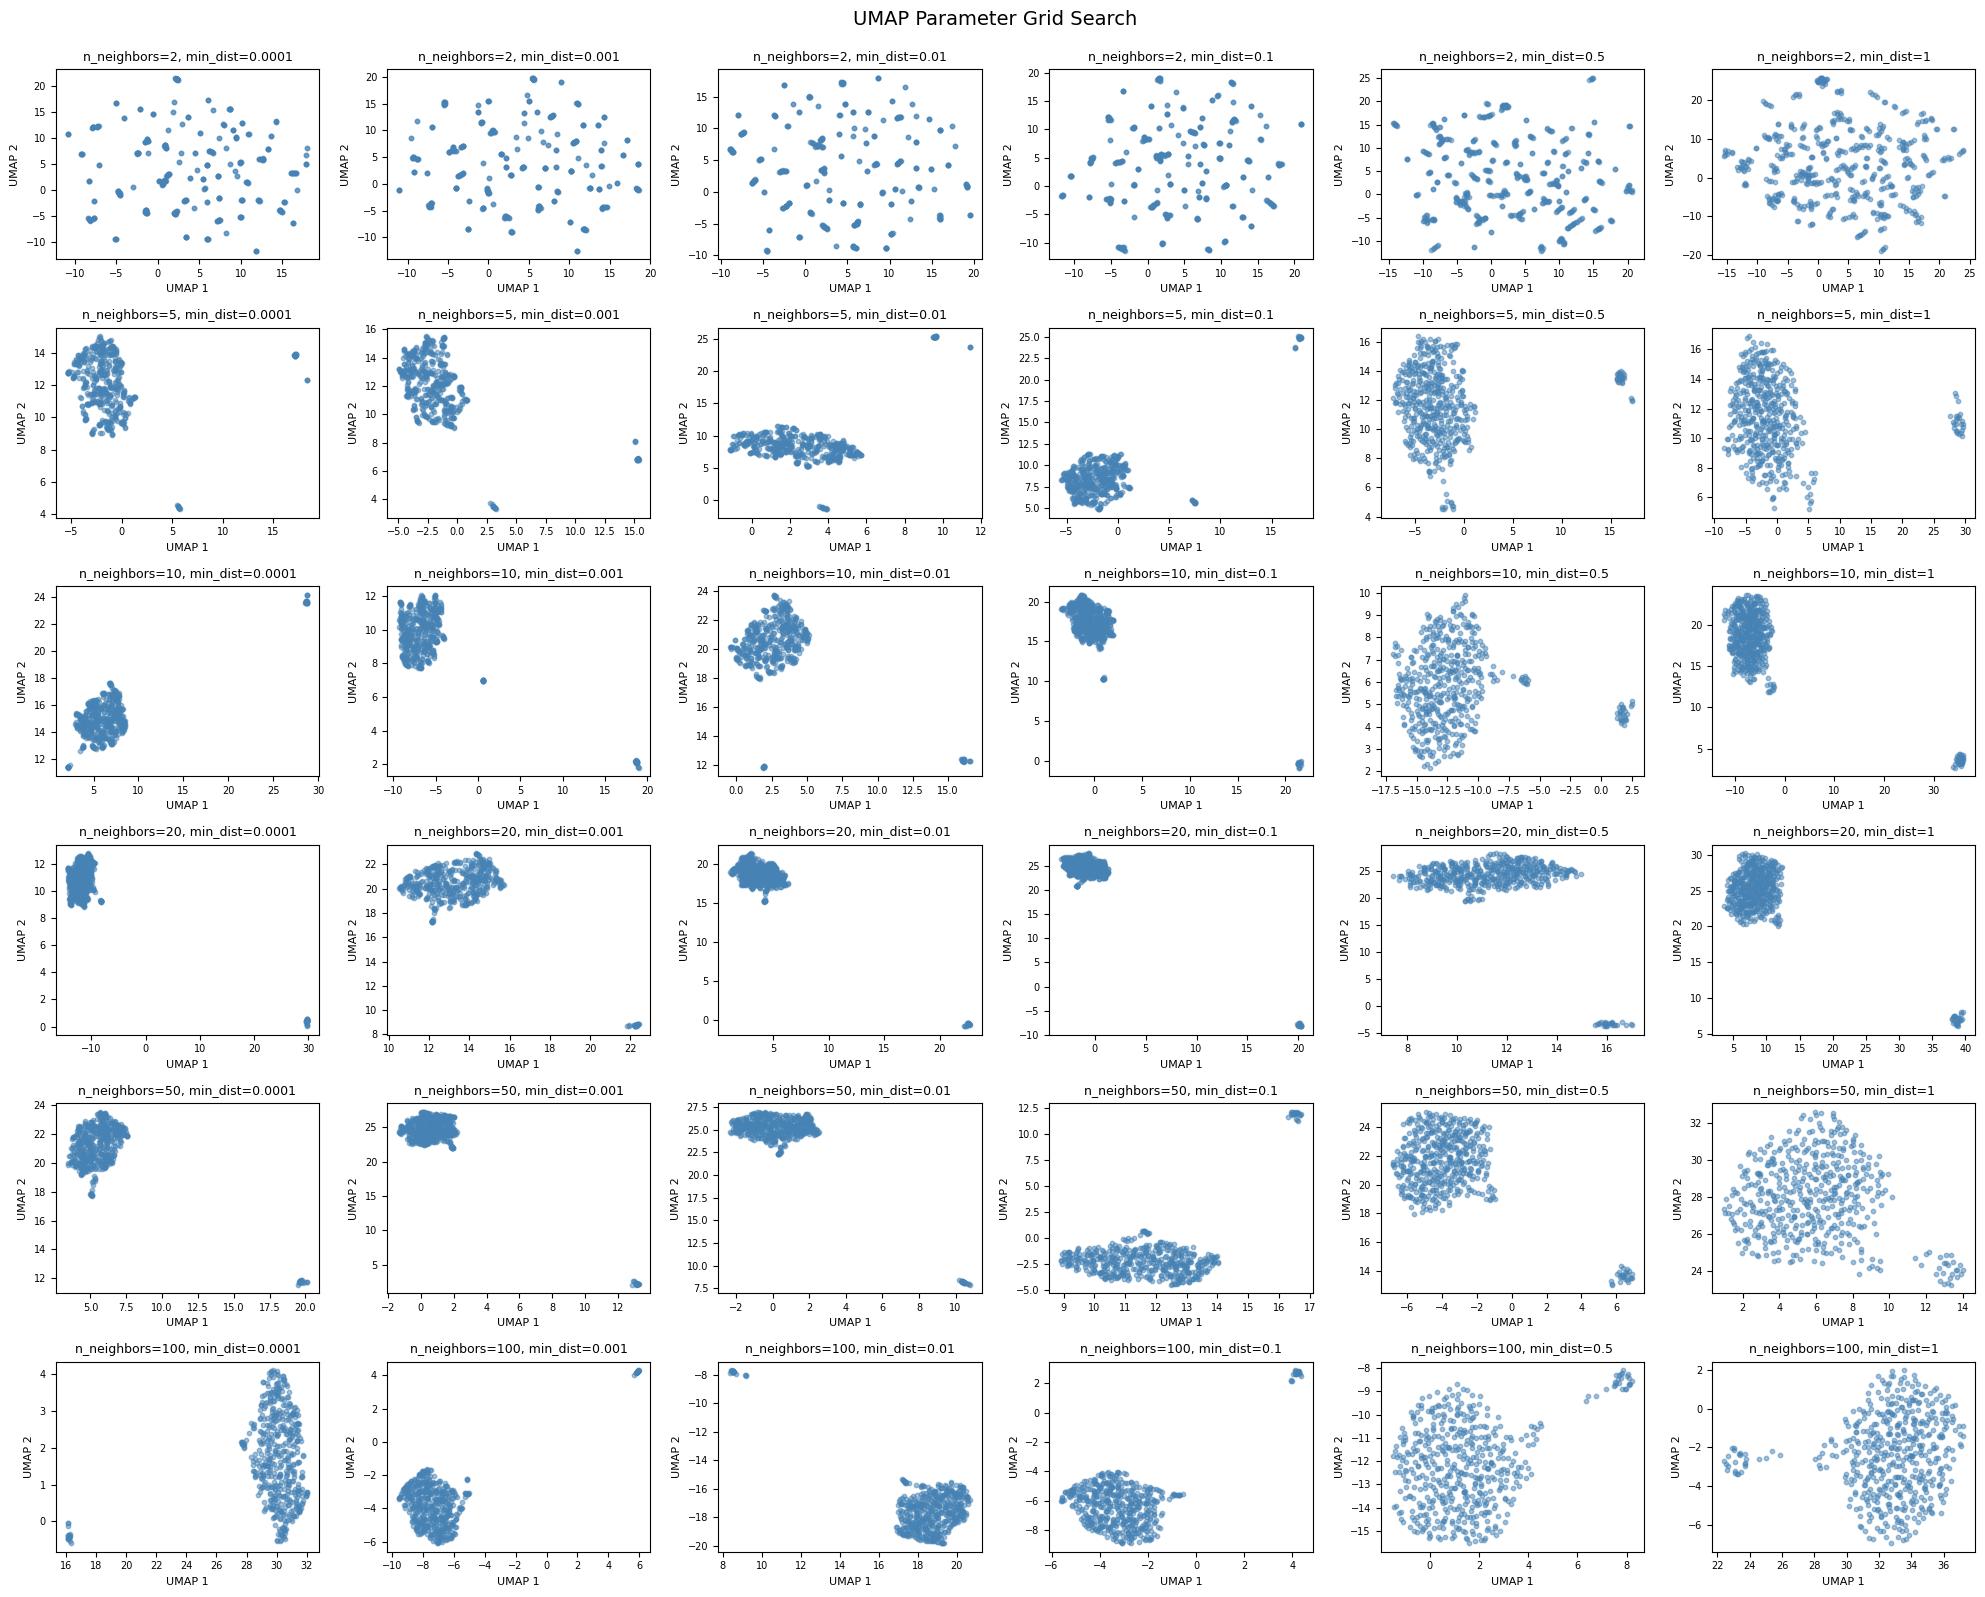

In [33]:
# Plot all combinations in a grid
fig, axes = plt.subplots(len(NEIGHBORS), len(MIN_DIST), figsize=(20, 16))

for i, result in enumerate(results):
    row = i // len(MIN_DIST)
    col = i % len(MIN_DIST)
    
    ax = axes[row, col]
    
    # Plot the 2D UMAP projection
    ax.scatter(result['embeddings'][:, 0], 
               result['embeddings'][:, 1], 
               alpha=0.5, s=10, c='steelblue')
    
    ax.set_title(f"n_neighbors={result['n_neighbors']}, min_dist={result['min_dist']}", 
                 fontsize=9)
    ax.set_xlabel('UMAP 1', fontsize=8)
    ax.set_ylabel('UMAP 2', fontsize=8)
    ax.tick_params(labelsize=7)

plt.suptitle('UMAP Parameter Grid Search', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

In [7]:
# Best UMAP
umap_model = umap.UMAP(
            n_components=2, 
            n_neighbors=2, 
            min_dist=1, 
            metric='cosine',
            random_state=42
        )

In [8]:
import hdbscan

MIN_CLUSTER_SIZE= 15
MIN_SAMPLES = 5
clustering_model = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    metric='euclidean',
    cluster_selection_method='eom',
    min_samples=MIN_SAMPLES,
    random_state=0
)

topic_model = BERTopic(
    embedding_model=emb_model,
    umap_model=umap_model,
    hdbscan_model=clustering_model, 
)

In [9]:
# Fit the BERTopic model on book descriptions
topics, probs = topic_model.fit_transform(descriptions)

TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'

In [20]:
# Check package versions
import sklearn
import hdbscan
print(f"scikit-learn version: {sklearn.__version__}")
try:
    print(f"hdbscan version: {hdbscan.__version__}")
except AttributeError:
    import pkg_resources
    print(f"hdbscan version: {pkg_resources.get_distribution('hdbscan').version}")

scikit-learn version: 1.8.0
hdbscan version: 0.8.40


In [6]:
topic_model = BERTopic()

In [7]:
input_folder = folder_path
output_root  = Path(f"{folder_path.name}_project_corpus")

pdf_paths = sorted(input_folder.glob("*.pdf"))

corpus_index = []

for i, pdf_path in enumerate(pdf_paths, start=1):
    paper_id = f"P{i:04d}"
    paper_out_dir = output_root / paper_id
    paper_out_dir.mkdir(parents=True, exist_ok=True)

    metadata_path = paper_out_dir / "metadata.json"

    # Skip if already processed
    if metadata_path.exists():
        print(f"Skipping {pdf_path.name} (already processed)")
        with open(metadata_path) as f:
            md = json.load(f)
        corpus_index.append(md)
        continue

    # --- Process with GROBID ---
    try:
        tei_xml = utils_KG.grobid_process_pdf_to_xml(pdf_path)
        (paper_out_dir / "fulltext.tei.xml").write_text(tei_xml)

        # Optional: extract plain text
        fulltext = utils_KG.extract_plain_text_from_tei(tei_xml)
        (paper_out_dir / "fulltext.txt").write_text(fulltext)

        # Extract metadata fields you want
        metadata = utils_KG.extract_metadata_fields(tei_xml, pdf_path, paper_id)
        with open(metadata_path, "w") as f:
            json.dump(metadata, f, indent=2)

    except Exception as e:
        # Show error in console (so you *see* the issue)
        print(f"[{paper_id}] ERROR while processing {pdf_path.name}: {e}")

        # Save full traceback for debugging
        import traceback
        err_text = f"Error processing {pdf_path.name}:\n\n{traceback.format_exc()}"
        (paper_out_dir / "error.txt").write_text(err_text, encoding="utf-8")

        # Continue loop
        continue

Skipping Albuquerque et al. 2021.pdf (already processed)
Skipping Amici et al. 2019.pdf (already processed)
Skipping Aniello et al. 2021.pdf (already processed)
